# Multiclass Text Classification with 
# Feed-forward Neural Networks and Word Embeddings

First, we will do some initialization.

In [1]:
import random
import torch
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# enable tqdm in pandas
tqdm.pandas()

# set to True to use the gpu (if there is one available)
use_gpu = True

# select device
device = torch.device('cuda' if use_gpu and torch.cuda.is_available() else 'cpu')
print(f'device: {device.type}')

# random seed
seed = 1234

# set random seed
if seed is not None:
    print(f'random seed: {seed}')
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

device: cpu
random seed: 1234


We will be using the AG's News Topic Classification Dataset.
It is stored in two CSV files: `train.csv` and `test.csv`, as well as a `classes.txt` that stores the labels of the classes to predict.

First, we will load the training dataset using [pandas](https://pandas.pydata.org/) and take a quick look at how the data.

In [2]:
train_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=None)
train_df.columns = ['class index', 'title', 'description']
train_df

,class index,title,description
0,Class Index,Title,Description
1,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
2,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
3,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
4,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
...,...,...,...
119996,1,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...
119997,2,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...
119998,2,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...
119999,2,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...


The dataset consists of 120,000 examples, each consisting of a class index, a title, and a description.
The class labels are distributed in a separated file. We will add the labels to the dataset so that we can interpret the data more easily. Note that the label indexes are one-based, so we need to subtract one to retrieve them from the list.

In [3]:
non_numeric = train_df[~train_df['class index'].str.isnumeric()]
print(non_numeric)

   class index  title  description
0  Class Index  Title  Description


In [4]:
train_df = train_df.drop(0).reset_index(drop=True)

In [5]:
non_numeric = train_df[~train_df['class index'].str.isnumeric()]
print(non_numeric)

Empty DataFrame
Columns: [class index, title, description]
Index: []


In [6]:
train_df['class index'] = train_df['class index'].astype(int)

In [7]:
labels = ['World', 'Sports', 'Business', 'Sci/Tech']
classes = train_df['class index'].map(lambda i: labels[i-1])
train_df.insert(1, 'class', classes)
train_df.head()

,class index,class,title,description
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco..."


Let's inspect how balanced our examples are by using a bar plot.

/tmp/ipykernel_30/1245903889.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  pd.value_counts(train_df['class']).plot.bar()


<Axes: xlabel='class'>

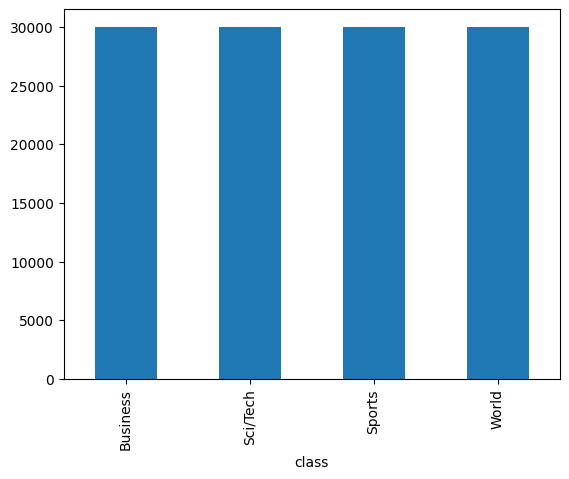

In [8]:
pd.value_counts(train_df['class']).plot.bar()

The classes are evenly distributed. That's great!

However, the text contains some spurious backslashes in some parts of the text.
They are meant to represent newlines in the original text.
An example can be seen below, between the words "dwindling" and "band".

In [9]:
print(train_df.loc[0, 'description'])

Reuters - Short-sellers, Wall Street's dwindling\band of ultra-cynics, are seeing green again.


We will replace the backslashes with spaces on the whole column using pandas replace method.

In [10]:
train_df['text'] = train_df['title'].str.lower() + " " + train_df['description'].str.lower()
train_df['text'] = train_df['text'].str.replace('\\', ' ', regex=False)
train_df

,class index,class,title,description,text
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new..."
...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...


Now we will proceed to tokenize the title and description columns using NLTK's word_tokenize().
We will add a new column to our dataframe with the list of tokens.

In [11]:
from nltk.tokenize import word_tokenize

train_df['tokens'] = train_df['text'].progress_map(word_tokenize)
train_df

  0%|          | 0/120000 [00:00<?, ?it/s]

,class index,class,title,description,text,tokens
0,3,Business,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",wall st. bears claw back into the black (reute...,"[wall, st., bears, claw, back, into, the, blac..."
1,3,Business,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,carlyle looks toward commercial aerospace (reu...,"[carlyle, looks, toward, commercial, aerospace..."
2,3,Business,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,oil and economy cloud stocks' outlook (reuters...,"[oil, and, economy, cloud, stocks, ', outlook,..."
3,3,Business,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,iraq halts oil exports from main southern pipe...,"[iraq, halts, oil, exports, from, main, southe..."
4,3,Business,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","oil prices soar to all-time record, posing new...","[oil, prices, soar, to, all-time, record, ,, p..."
...,...,...,...,...,...,...
119995,1,World,Pakistan's Musharraf Says Won't Quit as Army C...,KARACHI (Reuters) - Pakistani President Perve...,pakistan's musharraf says won't quit as army c...,"[pakistan, 's, musharraf, says, wo, n't, quit,..."
119996,2,Sports,Renteria signing a top-shelf deal,Red Sox general manager Theo Epstein acknowled...,renteria signing a top-shelf deal red sox gene...,"[renteria, signing, a, top-shelf, deal, red, s..."
119997,2,Sports,Saban not going to Dolphins yet,The Miami Dolphins will put their courtship of...,saban not going to dolphins yet the miami dolp...,"[saban, not, going, to, dolphins, yet, the, mi..."
119998,2,Sports,Today's NFL games,PITTSBURGH at NY GIANTS Time: 1:30 p.m. Line: ...,today's nfl games pittsburgh at ny giants time...,"[today, 's, nfl, games, pittsburgh, at, ny, gi..."


Now we will load the GloVe word embeddings.

In [12]:
from gensim.models import KeyedVectors
glove = KeyedVectors.load_word2vec_format("/kaggle/input/glove6b300dtxt/glove.6B.300d.txt", no_header=True)
glove.vectors.shape

(400000, 300)

The word embeddings have been pretrained in a different corpus, so it would be a good idea to estimate how good our tokenization matches the GloVe vocabulary.

In [13]:
from collections import Counter

def count_unknown_words(data, vocabulary):
    counter = Counter()
    for row in tqdm(data):
        counter.update(tok for tok in row if tok not in vocabulary)
    return counter

# find out how many times each unknown token occurrs in the corpus
c = count_unknown_words(train_df['tokens'], glove.key_to_index)

# find the total number of tokens in the corpus
total_tokens = train_df['tokens'].map(len).sum()

# find some statistics about occurrences of unknown tokens
unk_tokens = sum(c.values())
percent_unk = unk_tokens / total_tokens
distinct_tokens = len(list(c))

print(f'total number of tokens: {total_tokens:,}')
print(f'number of unknown tokens: {unk_tokens:,}')
print(f'number of distinct unknown tokens: {distinct_tokens:,}')
print(f'percentage of unkown tokens: {percent_unk:.2%}')
print('top 50 unknown words:')
for token, n in c.most_common(10):
    print(f'\t{n}\t{token}')

  0%|          | 0/120000 [00:00<?, ?it/s]

total number of tokens: 5,273,096
number of unknown tokens: 66,008
number of distinct unknown tokens: 24,792
percentage of unkown tokens: 1.25%
top 50 unknown words:
	2984	/b
	2119	href=
	2117	/a
	1813	//www.investor.reuters.com/fullquote.aspx
	1813	target=/stocks/quickinfo/fullquote
	537	/p
	510	newsfactor
	471	cbs.mw
	431	color=
	417	/font


Glove embeddings seem to have a good coverage on this dataset -- only 1.25% of the tokens in the dataset are unknown, i.e., don't appear in the GloVe vocabulary.

Still, we will need a way to handle these unknown tokens.
Our approach will be to add a new embedding to GloVe that will be used to represent them.
This new embedding will be initialized as the average of all the GloVe embeddings.

We will also add another embedding, this one initialized to zeros, that will be used to pad the sequences of tokens so that they all have the same length. This will be useful when we train with mini-batches.

In [14]:
# string values corresponding to the new embeddings
unk_tok = '[UNK]'
pad_tok = '[PAD]'

# initialize the new embedding values
unk_emb = glove.vectors.mean(axis=0)
pad_emb = np.zeros(300)

# add new embeddings to glove
glove.add_vectors([unk_tok, pad_tok], [unk_emb, pad_emb])

# get token ids corresponding to the new embeddings
unk_id = glove.key_to_index[unk_tok]
pad_id = glove.key_to_index[pad_tok]

unk_id, pad_id

(400000, 400001)

Aqui se extiende el modelo de embeddings preentrenado glove al agregar representaciones para tokens especiales de palabras desconocidas ([UNK]) y relleno ([PAD]). 

In [15]:
from sklearn.model_selection import train_test_split

train_df, dev_df = train_test_split(train_df, train_size=0.8)
train_df.reset_index(inplace=True)
dev_df.reset_index(inplace=True)

We will now add a new column to our dataframe that will contain the padded sequences of token ids.

In [16]:
threshold = 10
tokens = train_df['tokens'].explode().value_counts()
vocabulary = set(tokens[tokens > threshold].index.tolist())
print(f'vocabulary size: {len(vocabulary):,}')

vocabulary size: 17,441


In [17]:
# find the length of the longest list of tokens
max_tokens = train_df['tokens'].map(len).max()

# return unk_id for infrequent tokens too
def get_id(tok):
    if tok in vocabulary:
        return glove.key_to_index.get(tok, unk_id)
    else:
        return unk_id

# function that gets a list of tokens and returns a list of token ids,
# with padding added accordingly
def token_ids(tokens):
    tok_ids = [get_id(tok) for tok in tokens]
    pad_len = max_tokens - len(tok_ids)
    return tok_ids + [pad_id] * pad_len

# add new column to the dataframe
train_df['token ids'] = train_df['tokens'].progress_map(token_ids)
train_df

  0%|          | 0/96000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,9116,1,World,Najaf's Residents Feel Trapped in Battle (AP),"AP - For nearly three weeks, Amer al-Jamali ha...",najaf's residents feel trapped in battle (ap) ...,"[najaf, 's, residents, feel, trapped, in, batt...","[10709, 9, 1048, 998, 4799, 6, 903, 23, 1582, ..."
1,99831,3,Business,U.S. FDA Adds Restrictions to Acne Drug,WASHINGTON (Reuters) - Roche's acne drug Accu...,u.s. fda adds restrictions to acne drug washi...,"[u.s., fda, adds, restrictions, to, acne, drug...","[99, 5584, 2144, 3252, 4, 400000, 780, 289, 23..."
2,10663,3,Business,Smithfield Foods Profit More Than Doubles,"Smithfield Foods Inc. (SFD.N: Quote, Profile, ...",smithfield foods profit more than doubles smit...,"[smithfield, foods, profit, more, than, double...","[34026, 5008, 1269, 56, 73, 4229, 34026, 5008,..."
3,73175,4,Sci/Tech,PluggedIn: The OQO Is Not Just Another Handhel...,SAN FRANCISCO (Reuters) - A full-fledged Wind...,pluggedin: the oqo is not just another handhel...,"[pluggedin, :, the, oqo, is, not, just, anothe...","[400000, 45, 0, 293697, 14, 36, 120, 170, 2099..."
4,104494,4,Sci/Tech,IBM invigorates LTO tape storage,LTO (linear tape open)-based drives are invigo...,ibm invigorates lto tape storage lto (linear t...,"[ibm, invigorates, lto, tape, storage, lto, (,...","[5199, 400000, 400000, 4143, 4418, 400000, 23,..."
...,...,...,...,...,...,...,...,...
95995,89460,1,World,"Bush, Blair See Hope for Palestinian State (AP)","AP - As Yasser Arafat was buried, President Bu...","bush, blair see hope for palestinian state (ap...","[bush, ,, blair, see, hope, for, palestinian, ...","[272, 1, 2356, 253, 824, 10, 463, 92, 23, 1582..."
95996,60620,1,World,Ex-Soldiers Vow to Bring Order to Haiti Capital,Ex-soldiers who helped topple former President...,ex-soldiers vow to bring order to haiti capita...,"[ex-soldiers, vow, to, bring, order, to, haiti...","[223970, 12887, 4, 938, 460, 4, 3836, 351, 223..."
95997,34086,1,World,Musharraf says U.S. must address root of terro...,Reuters - The United States could lose its war...,musharraf says u.s. must address root of terro...,"[musharraf, says, u.s., must, address, root, o...","[3820, 210, 99, 390, 1476, 5440, 3, 1291, 23, ..."
95998,58067,1,World,Nuclear materials #39;vanish #39; in Iraq,Equipment and materials that could be used to ...,nuclear materials #39;vanish #39; in iraq equ...,"[nuclear, materials, #, 39, ;, vanish, #, 39, ...","[490, 2176, 2749, 3403, 89, 25736, 2749, 3403,..."


Se transforma las listas de tokens en el DataFrame en listas de IDs de tokens, aparte de asegurarnos que todas las secuencias tengan la misma longitud.

In [18]:
max_tokens = dev_df['tokens'].map(len).max()
dev_df['token ids'] = dev_df['tokens'].progress_map(token_ids)
dev_df

  0%|          | 0/24000 [00:00<?, ?it/s]

,index,class index,class,title,description,text,tokens,token ids
0,60974,1,World,Sharon Accepts Plan to Reduce Gaza Army Operat...,Israeli Prime Minister Ariel Sharon accepted a...,sharon accepts plan to reduce gaza army operat...,"[sharon, accepts, plan, to, reduce, gaza, army...","[2548, 9889, 394, 4, 1680, 1166, 330, 957, 1, ..."
1,50391,4,Sci/Tech,Internet Key Battleground in Wildlife Crime Fight,Why trawl through a sweaty illegal\wildlife ma...,internet key battleground in wildlife crime fi...,"[internet, key, battleground, in, wildlife, cr...","[925, 638, 14944, 6, 4446, 1340, 838, 738, 400..."
2,9307,3,Business,July Durable Good Orders Rise 1.7 Percent,America's factories saw orders for costly manu...,july durable good orders rise 1.7 percent amer...,"[july, durable, good, orders, rise, 1.7, perce...","[375, 10699, 219, 1949, 1027, 6262, 72, 453, 9..."
3,35221,3,Business,Growing Signs of a Slowing on Wall Street,"all Street #39;s earnings growth, fueled by tw...",growing signs of a slowing on wall street all ...,"[growing, signs, of, a, slowing, on, wall, str...","[988, 1867, 3, 7, 6515, 13, 1015, 491, 64, 491..."
4,40081,1,World,The New Faces of Reality TV,The introduction of children to the genre was ...,the new faces of reality tv the introduction o...,"[the, new, faces, of, reality, tv, the, introd...","[0, 50, 1919, 3, 2532, 816, 0, 4344, 3, 271, 4..."
...,...,...,...,...,...,...,...,...
23995,49572,1,World,Iraqi Kidnappers Release 2 Indonesian Women,Two Indonesian women held hostage for several ...,iraqi kidnappers release 2 indonesian women tw...,"[iraqi, kidnappers, release, 2, indonesian, wo...","[710, 9349, 713, 232, 2656, 266, 55, 2656, 266..."
23996,40409,4,Sci/Tech,Big Wi-Fi Project for Philadelphia,What would Benjamin Franklin say? Philadelphia...,big wi-fi project for philadelphia what would ...,"[big, wi-fi, project, for, philadelphia, what,...","[365, 39300, 716, 10, 2201, 102, 54, 4067, 503..."
23997,70470,2,Sports,Owen scores again,Michael Owen scored the winner for Real Madrid...,owen scores again michael owen scored the winn...,"[owen, scores, again, michael, owen, scored, t...","[7116, 2776, 378, 785, 7116, 878, 0, 1364, 10,..."
23998,7941,4,Sci/Tech,US Online Retail Sales Expected To Double In S...,Online retail sales in the US are expected to ...,us online retail sales expected to double in s...,"[us, online, retail, sales, expected, to, doub...","[95, 1292, 2645, 526, 287, 4, 1278, 6, 228, 82..."


Now we will get a numpy 2-dimensional array corresponding to the token ids,
and a 1-dimensional array with the gold classes. Note that the classes are one-based (i.e., they start at one),
but we need them to be zero-based, so we need to subtract one from this array.

In [19]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        x = torch.tensor(self.x[index])
        y = torch.tensor(self.y[index])
        return x, y

Definimos la función __getitem__, la clase permite acceder a los ejemplos de datos de una manera que se pueda utilizar para el entrenamiento por lotes.

Next, we construct our PyTorch model, which is a feed-forward neural network with two layers:

In [20]:
from torch import nn
import torch.nn.functional as F

class Model(nn.Module):
    def __init__(self, vectors, pad_id, hidden_dim, output_dim, dropout):
        super().__init__()
        # embeddings must be a tensor
        if not torch.is_tensor(vectors):
            vectors = torch.tensor(vectors)
        # keep padding id
        self.padding_idx = pad_id
        # embedding layer
        self.embs = nn.Embedding.from_pretrained(vectors, padding_idx=pad_id)
        # feedforward layers
        self.layers = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(vectors.shape[1], hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, output_dim),
        )
        
    def forward(self, x):
        # get boolean array with padding elements set to false
        not_padding = torch.isin(x, self.padding_idx, invert=True)
        # get lengths of examples (excluding padding)
        lengths = torch.count_nonzero(not_padding, axis=1)
        # get embeddings
        x = self.embs(x)
        # calculate means
        x = x.sum(dim=1) / lengths.unsqueeze(dim=1)
        # pass to rest of the model
        output = self.layers(x)
        # calculate softmax if we're not in training mode
        #if not self.training:
        #    output = F.softmax(output, dim=1)
        return output

Se convierte los tokens en embeddings usando vectores preentrenados, calcula la media de los embeddings de cada secuencia (excluyendo el padding), y pasa el resultado por una red completamente conectada para obtener la salida.

Next, we implement the training procedure. We compute the loss and accuracy on the development partition after each epoch.

In [21]:
from torch import optim
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score

# hyperparameters
lr = 1e-3
weight_decay = 0
batch_size = 500
shuffle = True
n_epochs = 5
hidden_dim = 50
output_dim = len(labels)
dropout = 0.1
vectors = glove.vectors

# initialize the model, loss function, optimizer, and data-loader
model = Model(vectors, pad_id, hidden_dim, output_dim, dropout).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
train_ds = MyDataset(train_df['token ids'], train_df['class index'] - 1)
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=shuffle)
dev_ds = MyDataset(dev_df['token ids'], dev_df['class index'] - 1)
dev_dl = DataLoader(dev_ds, batch_size=batch_size, shuffle=shuffle)

train_loss = []
train_acc = []

dev_loss = []
dev_acc = []

# train the model
for epoch in range(n_epochs):
    losses = []
    gold = []
    pred = []
    model.train()
    for X, y_true in tqdm(train_dl, desc=f'epoch {epoch+1} (train)'):
        # clear gradients
        model.zero_grad()
        # send batch to right device
        X = X.to(device)
        y_true = y_true.to(device)
        # predict label scores
        y_pred = model(X)
        # compute loss
        loss = loss_func(y_pred, y_true)
        # accumulate for plotting
        losses.append(loss.detach().cpu().item())
        gold.append(y_true.detach().cpu().numpy())
        pred.append(np.argmax(y_pred.detach().cpu().numpy(), axis=1))
        # backpropagate
        loss.backward()
        # optimize model parameters
        optimizer.step()
    train_loss.append(np.mean(losses))
    train_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))
    
    model.eval()
    with torch.no_grad():
        losses = []
        gold = []
        pred = []
        for X, y_true in tqdm(dev_dl, desc=f'epoch {epoch+1} (dev)'):
            X = X.to(device)
            y_true = y_true.to(device)
            y_pred = model(X)
            loss = loss_func(y_pred, y_true)
            losses.append(loss.cpu().item())
            gold.append(y_true.cpu().numpy())
            pred.append(np.argmax(y_pred.cpu().numpy(), axis=1))
        dev_loss.append(np.mean(losses))
        dev_acc.append(accuracy_score(np.concatenate(gold), np.concatenate(pred)))

epoch 1 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 1 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 2 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 2 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 3 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 3 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 4 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 4 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

epoch 5 (train):   0%|          | 0/192 [00:00<?, ?it/s]

epoch 5 (dev):   0%|          | 0/48 [00:00<?, ?it/s]

Se entrena un modelo de clasificación multiclase utilizando embeddings preentrenados (GloVe), con optimización mediante Adam

Let's plot the loss and accuracy on dev:

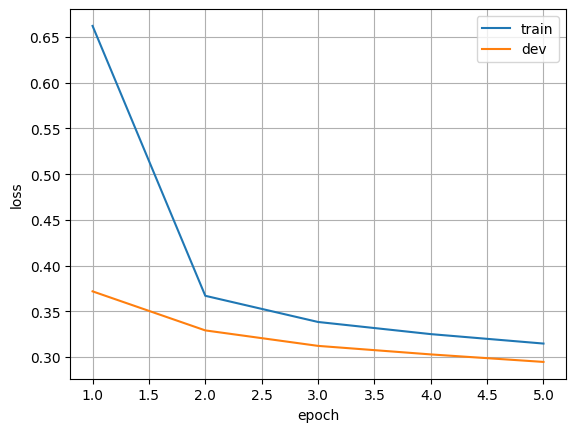

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

x = np.arange(n_epochs) + 1

plt.plot(x, train_loss)
plt.plot(x, dev_loss)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.grid(True)

Monitoreamos la funcion de perdida

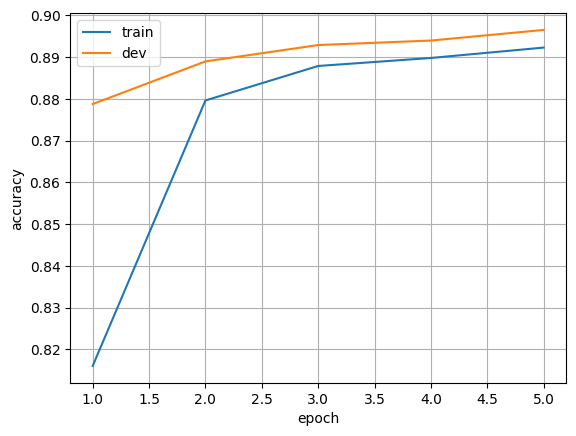

In [23]:
plt.plot(x, train_acc)
plt.plot(x, dev_acc)
plt.legend(['train', 'dev'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.grid(True)

Next, we evaluate on the testing partition:

In [24]:
# repeat all preprocessing done above, this time on the test set
test_df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=None)
test_df.columns = ['class index', 'title', 'description']

test_df = test_df.drop(0).reset_index(drop=True)
test_df['class index'] = test_df['class index'].astype(int)

test_df['text'] = test_df['title'].str.lower() + " " + test_df['description'].str.lower()
test_df['text'] = test_df['text'].str.replace('\\', ' ', regex=False)
test_df['tokens'] = test_df['text'].progress_map(word_tokenize)
max_tokens = dev_df['tokens'].map(len).max()
test_df['token ids'] = test_df['tokens'].progress_map(token_ids)

  0%|          | 0/7600 [00:00<?, ?it/s]

  0%|          | 0/7600 [00:00<?, ?it/s]

Hacemos el preprocesamiento necesario en el conjunto de datos de prueba para convertir el texto en secuencias de tokens, asignar IDs a los tokens y normalizar la longitud de las secuencias.

In [25]:
from sklearn.metrics import classification_report

# set model to evaluation mode
model.eval()

dataset = MyDataset(test_df['token ids'], test_df['class index'] - 1)
data_loader = DataLoader(dataset, batch_size=batch_size)
y_pred = []

# don't store gradients
with torch.no_grad():
    for X, _ in tqdm(data_loader):
        X = X.to(device)
        # predict one class per example
        y = torch.argmax(model(X), dim=1)
        # convert tensor to numpy array (sending it back to the cpu if needed)
        y_pred.append(y.cpu().numpy())
        # print results
    print(classification_report(dataset.y, np.concatenate(y_pred), target_names=labels))

  0%|          | 0/16 [00:00<?, ?it/s]

              precision    recall  f1-score   support

       World       0.92      0.89      0.90      1900
      Sports       0.95      0.98      0.96      1900
    Business       0.86      0.84      0.85      1900
    Sci/Tech       0.86      0.88      0.87      1900

    accuracy                           0.90      7600
   macro avg       0.90      0.90      0.90      7600
weighted avg       0.90      0.90      0.90      7600



Podemos observar que el modelo tiene un buen rendimiento general, con una precisión promedio del 90% y un f1-score macro promedio de 0.90.